# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5), (0.5))
])

# Create training set 
train = torchvision.datasets.MNIST(root='data', download=True, train=True, transform=transform)

# Create test set and define test dataloader
test = torchvision.datasets.MNIST(root='data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=32)


In [6]:
# Create validation set from train dataset

train_set, val_set = train_test_split(train, test_size=0.2, random_state=13)

# define train and val dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=32)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

While the MNIST dataset is preprocessed to some extent, it's still beneficial to preprocess it further using PyTorch transforms for a few reasons:

- Normalization: MNIST images have pixel values ranging from 0 to 255. Neural networks typically work better with data normalized to a smaller range, like 0 to 1 or -1 to 1. PyTorch's transforms.Normalize helps achieve this.
- Tensor Conversion: The MNIST dataset is loaded as PIL images by default. For training in PyTorch models, the data needs to be in tensor format. transforms.ToTensor() converts PIL images to tensors.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [8]:
print(f'Training size: {len(train)}')
print(f'Test size: {len(test)}')

Training size: 60000
Test size: 10000


In [9]:
len(train_loader)

1500

In [10]:
len(val_loader)

375

In [11]:
len(test_loader)

313

6


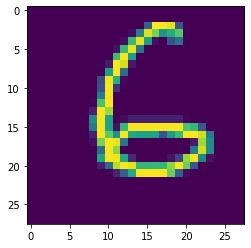

8


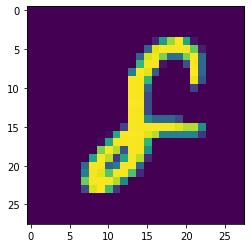

8


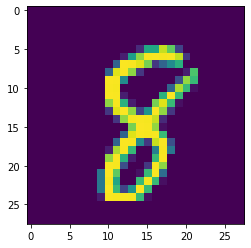

0


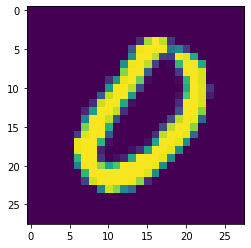

4


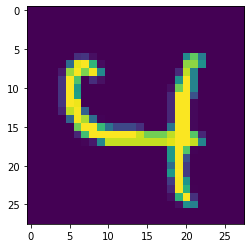

In [12]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(1 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [15]:
num_epochs = 50

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    print('EPOCH', epoch)
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1, keepdim=True)
        train_correct += preds.eq(labels.view_as(preds)).sum().item()
        train_loss += loss.item()
        if not i % 20:
            print('.', end='', flush=True)        
    print(f'\ntraining accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(dim=1, keepdim=True)
        val_correct += preds.eq(labels.view_as(preds)).sum().item()
        val_loss += loss.item()
        if not i % 20:
            print('.', end='', flush=True)
    val_loss_history.append(val_loss/len(val_loader))
    print(f'validation accuracy: {val_correct/len(val_loader):.2f}% validation loss: {val_loss/len(val_loader):.5f}')
    

EPOCH 0
...........................................................................
training accuracy: 24.86% training loss: 0.81666
validation accuracy: 28.40% validation loss: 0.39029
EPOCH 1
...........................................................................
training accuracy: 28.80% training loss: 0.33802
validation accuracy: 29.13% validation loss: 0.31007
EPOCH 2
...........................................................................
training accuracy: 29.31% training loss: 0.28505
validation accuracy: 29.41% validation loss: 0.28027
EPOCH 3
...........................................................................
training accuracy: 29.65% training loss: 0.24651
validation accuracy: 29.73% validation loss: 0.23792
EPOCH 4
...........................................................................
training accuracy: 29.92% training loss: 0.21639
validation accuracy: 29.82% validation loss: 0.22596
EPOCH 5
..............................................................

...........................................................................
training accuracy: 31.90% training loss: 0.01492
validation accuracy: 31.23% validation loss: 0.08725
EPOCH 45
...........................................................................
training accuracy: 31.91% training loss: 0.01368
validation accuracy: 31.21% validation loss: 0.09116
EPOCH 46
...........................................................................
training accuracy: 31.92% training loss: 0.01306
validation accuracy: 31.19% validation loss: 0.08960
EPOCH 47
...........................................................................
training accuracy: 31.92% training loss: 0.01231
validation accuracy: 31.19% validation loss: 0.08811
EPOCH 48
...........................................................................
training accuracy: 31.94% training loss: 0.01146
validation accuracy: 31.20% validation loss: 0.08850
EPOCH 49
.................................................................

Plot the training loss (and validation loss/accuracy, if recorded).

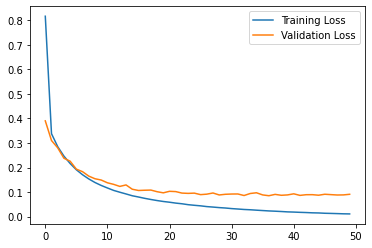

In [16]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [17]:
def testing(model, criterion):
    test_loss = 0.0
    correct   = 0.0
    total     = 0.0
    
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total   += data.size(0)
        
    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [18]:
testing(net, criterion)

Test Loss: 0.077216
Test Accuracy: 97% (9771/10000)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 50

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    print('EPOCH', epoch)
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1, keepdim=True)
        train_correct += preds.eq(labels.view_as(preds)).sum().item()
        train_loss += loss.item()
        if not i % 20:
            print('.', end='', flush=True)        
    print(f'\ntraining accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(dim=1, keepdim=True)
        val_correct += preds.eq(labels.view_as(preds)).sum().item()
        val_loss += loss.item()
        if not i % 20:
            print('.', end='', flush=True)
    val_loss_history.append(val_loss/len(val_loader))
    print(f'validation accuracy: {val_correct/len(val_loader):.2f}% validation loss: {val_loss/len(val_loader):.5f}')
    

EPOCH 0
...........................................................................
training accuracy: 30.57% training loss: 0.14619
validation accuracy: 30.55% validation loss: 0.16088
EPOCH 1
...........................................................................
training accuracy: 30.83% training loss: 0.11401
validation accuracy: 30.78% validation loss: 0.12953
EPOCH 2
...........................................................................
training accuracy: 30.96% training loss: 0.09766
validation accuracy: 30.72% validation loss: 0.14009
EPOCH 3
...........................................................................
training accuracy: 31.07% training loss: 0.08972
validation accuracy: 30.77% validation loss: 0.13707
EPOCH 4
...........................................................................
training accuracy: 31.14% training loss: 0.08226
validation accuracy: 30.98% validation loss: 0.11680
EPOCH 5
..............................................................

...........................................................................
training accuracy: 31.82% training loss: 0.01775
validation accuracy: 31.20% validation loss: 0.18895
EPOCH 45
...........................................................................
training accuracy: 31.81% training loss: 0.01889
validation accuracy: 31.09% validation loss: 0.22970
EPOCH 46
...........................................................................
training accuracy: 31.82% training loss: 0.01981
validation accuracy: 31.20% validation loss: 0.18477
EPOCH 47
...........................................................................
training accuracy: 31.82% training loss: 0.01884
validation accuracy: 31.09% validation loss: 0.20566
EPOCH 48
...........................................................................
training accuracy: 31.82% training loss: 0.01787
validation accuracy: 31.20% validation loss: 0.18397
EPOCH 49
.................................................................

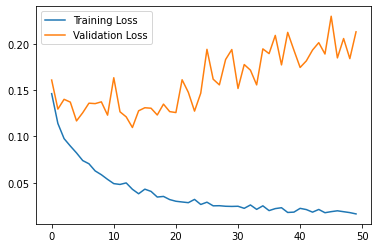

In [23]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Saving your model
Using `torch.save`, save your model for future loading.

In [25]:
# Specify the file path where you want to save the model
model_path = 'mnist_model.pt'

# Save the model
torch.save(net.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to mnist_model.pt
